In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
from datetime import date
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
electricity = pd.read_csv("C:/Users/kacpe/Desktop/Projekt_3/household_power_consumption.txt", sep = ';', low_memory = False )

### Opis zbioru:

### Opis zbioru:

**date:** Date in format dd/mm/yyyy

**time:** time in format hh:mm:ss

**globalactivepower:** household global minute-averaged active power (in kilowatt)

**globalreactivepower:** household global minute-averaged reactive power (in kilowatt)

**voltage:** minute-averaged voltage (in volt)

**global_intensity:** household global minute-averaged current intensity (in ampere)

**submetering1:** energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

**submetering2:** energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

**submetering3:** energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### Sprawdzenie czy nie brakuje jakiejś daty:

In [3]:
len(electricity["Date"].unique())

1442

Wniosek: Są wszystkie dni w analizowanym zakresie.

### Sprawdzenie czy nie brakuje jakiejś godziny:

In [4]:
electricity_hour = electricity[["Date", "Time"]].groupby("Date").agg("count").reset_index()
electricity_hour[electricity_hour["Time"] != 1440]

,Date,Time
341,16/12/2006,396
867,26/11/2010,1263


Wniosek: Poza pierwszym i ostatnim dniem, mamy dla każdego z dni odczyt co minutę.

### Sprawdzenie ilości braków:

In [5]:
electricity.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
proc_na_Sub_metering_3 = electricity["Sub_metering_3"].isna().sum()/len(electricity["Sub_metering_3"])

In [7]:
proc_na_Sub_metering_3

0.012518437457686004

In [8]:
electricity[electricity["Global_active_power"] == '?']

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...,...
1990185,28/9/2010,19:09:00,?,?,?,?,?,?,NaN
1990186,28/9/2010,19:10:00,?,?,?,?,?,?,NaN
1990187,28/9/2010,19:11:00,?,?,?,?,?,?,NaN
1990188,28/9/2010,19:12:00,?,?,?,?,?,?,NaN


In [9]:
list_columns = []

for column in electricity.columns:
    list_columns.append(column)

In [10]:
list_columns

['Date',
 'Time',
 'Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

Jak widać te wartości, które mają braki, mają braki jednak wszędzie. Wstępnie usuwam, to tylko 1,2%, ewentualnie można sprawdzić w jakich dniach.

### Sprawdzenie typów, grupowania:

In [11]:
electricity = electricity.dropna()

In [12]:
electricity.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [13]:
electricity["Date"] = pd.to_datetime(electricity["Date"], format='%d/%m/%Y')

In [14]:
electricity["Hour"] = electricity["Time"].str.split(':')
electricity["Hour"] = electricity["Time"].str.split(':', expand=True)

In [15]:
electricity["Global_active_power"] = electricity["Global_active_power"].astype('float')
electricity["Global_reactive_power"] = electricity["Global_reactive_power"].astype('float')
electricity["Voltage"] = electricity["Voltage"].astype('float')
electricity["Global_intensity"] = electricity["Global_intensity"].astype('float')
electricity["Sub_metering_1"] = electricity["Sub_metering_1"].astype('float')
electricity["Sub_metering_2"] = electricity["Sub_metering_2"].astype('float')
electricity["Sub_metering_3"] = electricity["Sub_metering_3"].astype('float')

In [16]:

electricity_hour=electricity.groupby(['Date', 'Hour']).agg({'Global_active_power':'sum', 
                                                           'Global_reactive_power':'sum',
                                                           'Voltage':'mean', 
                                                           'Global_intensity':'mean',
                                                           'Sub_metering_1':'sum',
                                                           'Sub_metering_2':'sum',
                                                           'Sub_metering_3':'sum'}).reset_index()

electricity_day=electricity.groupby('Date').agg({'Global_active_power':'sum', 
                                                           'Global_reactive_power':'sum',
                                                           'Voltage':'mean', 
                                                           'Global_intensity':'mean',
                                                           'Sub_metering_1':'sum',
                                                           'Sub_metering_2':'sum',
                                                           'Sub_metering_3':'sum'}).reset_index()

In [17]:
electricity_hour["Hour"] = electricity_hour["Hour"].astype('int')

### Dostawienie kolumn:

#### Pora roku:

In [18]:
import pandas as pd

def get_season(date_time):
    # dummy leap year to include leap days(year-02-29) in our range
    leap_year = 2000
    seasons = [('winter', (date(leap_year, 1, 1), date(leap_year, 3, 20))),
               ('spring', (date(leap_year, 3, 21), date(leap_year, 6, 20))),
               ('summer', (date(leap_year, 6, 21), date(leap_year, 9, 22))),
               ('autumn', (date(leap_year, 9, 23), date(leap_year, 12, 20))),
               ('winter', (date(leap_year, 12, 21), date(leap_year, 12, 31)))]

    if isinstance(date_time, datetime):
        date_time = date_time.date()
        
    # we don't really care about the actual year so replace it with our dummy leap_year
    date_time = date_time.replace(year=leap_year)
    # return season our date falls in.
    return next(season for season, (start, end) in seasons
                if start <= date_time <= end)


def create_season_column(data_set, date_column):
    # cloning the input dataset.
    local = data_set.copy()
    # The apply method calls a function on each row
    local['Season'] = local[date_column].apply(get_season)
    return local

electricity_day = create_season_column(electricity_day, date_column='Date')
electricity_hour = create_season_column(electricity_hour, date_column='Date')

#### Pora dnia:

In [19]:
hours_list = [0,4,8,12,16,20,24]
time_a_day_list = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
#electricity['Time_a_day_long'] = pd.cut(electricity['Time'].dt.hour , bins=hours_list, labels=time_a_day_list, include_lowest=True)



electricity_hour['Time_a_day_long'] = pd.cut(electricity_hour['Hour'] , bins=hours_list, labels=time_a_day_list, include_lowest=True)

#### Dzień tygodnia:

In [20]:
electricity_hour['day_of_week'] = electricity_hour['Date'].dt.day_name()
electricity_day['day_of_week'] = electricity_day['Date'].dt.day_name()

In [21]:
electricity_hour["Date"].dt.year.unique()

array([2006, 2007, 2008, 2009, 2010], dtype=int64)

### Transformacja zbiorów - dołożenie obserwacji sprzed roku:

In [128]:
electricity_hour_2007 = electricity_hour[electricity_hour["Date"].dt.year == 2007]
electricity_hour_2008 = electricity_hour[electricity_hour["Date"].dt.year == 2008]
electricity_hour_2009 = electricity_hour[electricity_hour["Date"].dt.year == 2009]
electricity_hour_2010_test = electricity_hour[electricity_hour["Date"].dt.year == 2010]
electricity_hour_2009_test = electricity_hour_2009[electricity_hour_2009["Date"] <'2009-11-27 ']
electricity_hour_2008_test = electricity_hour_2008[electricity_hour_2008["Date"] <'2008-11-27 ']

In [129]:
electricity_hour_2007["Date"] = electricity_hour_2007["Date"] + pd.offsets.DateOffset(years=2)
electricity_hour_2008["Date"] = electricity_hour_2008["Date"] + pd.offsets.DateOffset(years=1)

electricity_hour_2009_test["Date"] = electricity_hour_2009_test["Date"] + pd.offsets.DateOffset(years=1)
electricity_hour_2008_test["Date"] = electricity_hour_2008_test["Date"] + pd.offsets.DateOffset(years=2)

<ipython-input-129-022c85b8b882>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_hour_2007["Date"] = electricity_hour_2007["Date"] + pd.offsets.DateOffset(years=2)
<ipython-input-129-022c85b8b882>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_hour_2008["Date"] = electricity_hour_2008["Date"] + pd.offsets.DateOffset(years=1)
<ipython-input-129-022c85b8b882>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [130]:
test = electricity_hour_2010_test.merge(electricity_hour_2009_test, 
                                        on = ["Date", "Hour", 'Season', 'Time_a_day_long',],
                                        how = 'left',
                                        suffixes = ['_2010','_2009']
                                       )

test = test.merge(electricity_hour_2008_test, 
                  on = ["Date", "Hour", 'Season', 'Time_a_day_long',],
                  how = 'left',)


train = electricity_hour_2009.merge(electricity_hour_2008, 
                                        on = ["Date", "Hour", 'Season', 'Time_a_day_long',],
                                        how = 'left',
                                        suffixes = ['_2009','_2008']
                                       )


train = train.merge(electricity_hour_2007, 
                  on = ["Date", "Hour", 'Season', 'Time_a_day_long',],
                  how = 'left',
                                       )

test = test.rename(columns = {'Global_active_power':'Global_active_power_2008',
                             'Global_reactive_power':'Global_reactive_power_2008',
                             'Voltage':'Voltage_2008',
                             'Global_intensity':'Global_intensity_2008',
                             'Sub_metering_1':'Sub_metering_1_2008',
                             'Sub_metering_2':'Sub_metering_2_2008',
                             'Sub_metering_3':'Sub_metering_3_2008',
                             'day_of_week':'day_of_week_2008'})

train = train.rename(columns = {'Global_active_power':'Global_active_power_2007',
                             'Global_reactive_power':'Global_reactive_power_2007',
                             'Voltage':'Voltage_2007',
                             'Global_intensity':'Global_intensity_2007',
                             'Sub_metering_1':'Sub_metering_1_2007',
                             'Sub_metering_2':'Sub_metering_2_2007',
                             'Sub_metering_3':'Sub_metering_3_2007',
                             'day_of_week':'day_of_week_2007'})

print(train.shape)
print(test.shape)


(8716, 28)
(7651, 28)


In [134]:
train.head(10)

,Date,Hour,Global_active_power_2009,Global_reactive_power_2009,Voltage_2009,Global_intensity_2009,Sub_metering_1_2009,Sub_metering_2_2009,Sub_metering_3_2009,Season,...,Sub_metering_3_2008,day_of_week_2008,Global_active_power_2007,Global_reactive_power_2007,Voltage_2007,Global_intensity_2007,Sub_metering_1_2007,Sub_metering_2_2007,Sub_metering_3_2007,day_of_week_2007
0,2009-01-01,0,32.096,3.684,246.872667,2.396667,0.0,0.0,0.0,winter,...,1074.0,Tuesday,153.038,6.768,241.361333,10.530000,0.0,35.0,0.0,Monday
1,2009-01-01,1,32.428,5.260,244.144333,2.446667,0.0,0.0,0.0,winter,...,1068.0,Tuesday,151.404,4.298,241.096500,10.443333,0.0,0.0,0.0,Monday
2,2009-01-01,2,34.522,5.912,246.402167,2.543333,0.0,31.0,0.0,winter,...,1084.0,Tuesday,154.940,6.400,243.200167,10.540000,0.0,20.0,0.0,Monday
3,2009-01-01,3,31.590,3.300,245.246500,2.373333,0.0,0.0,0.0,winter,...,1077.0,Tuesday,152.500,5.406,243.265667,10.400000,0.0,16.0,0.0,Monday
4,2009-01-01,4,31.314,3.276,245.003333,2.346667,0.0,0.0,0.0,winter,...,1069.0,Tuesday,148.544,5.290,242.456167,10.110000,0.0,0.0,0.0,Monday
5,2009-01-01,5,33.920,4.110,244.563667,2.496667,0.0,30.0,0.0,winter,...,1065.0,Tuesday,148.574,6.100,242.348667,10.150000,0.0,35.0,0.0,Monday
6,2009-01-01,6,85.588,4.408,243.298667,5.900000,0.0,0.0,900.0,winter,...,341.0,Tuesday,147.348,5.168,241.221833,10.103333,0.0,0.0,0.0,Monday
7,2009-01-01,7,36.124,4.902,240.906667,2.716667,0.0,5.0,78.0,winter,...,0.0,Tuesday,146.832,6.412,240.314167,10.120000,0.0,33.0,0.0,Monday
8,2009-01-01,8,32.846,4.788,241.298333,2.483333,0.0,26.0,0.0,winter,...,0.0,Tuesday,146.504,4.686,241.143167,10.046667,0.0,3.0,0.0,Monday
9,2009-01-01,9,31.504,2.432,240.558667,2.393333,0.0,0.0,0.0,winter,...,0.0,Tuesday,188.768,4.056,239.778833,13.053333,0.0,0.0,722.0,Monday


#### Dummies

In [127]:
train = pd.get_dummies(data=train, columns=['Season',  'Time_a_day_long', 'day_of_week_2007', 'day_of_week_2008', 'day_of_week_2009' ], drop_first = True)
test = pd.get_dummies(data=test,   columns=['Season',  'Time_a_day_long', 'day_of_week_2008', 'day_of_week_2009', 'day_of_week_2010' ], drop_first = True)

KeyError: "None of [Index(['Season', 'Time_a_day_long', 'day_of_week_2007', 'day_of_week_2008',\n       'day_of_week_2009'],\n      dtype='object')] are in the [columns]"

In [58]:
print(train.shape)
print(test.shape)

(8716, 49)
(7651, 49)


#### Korelacje:

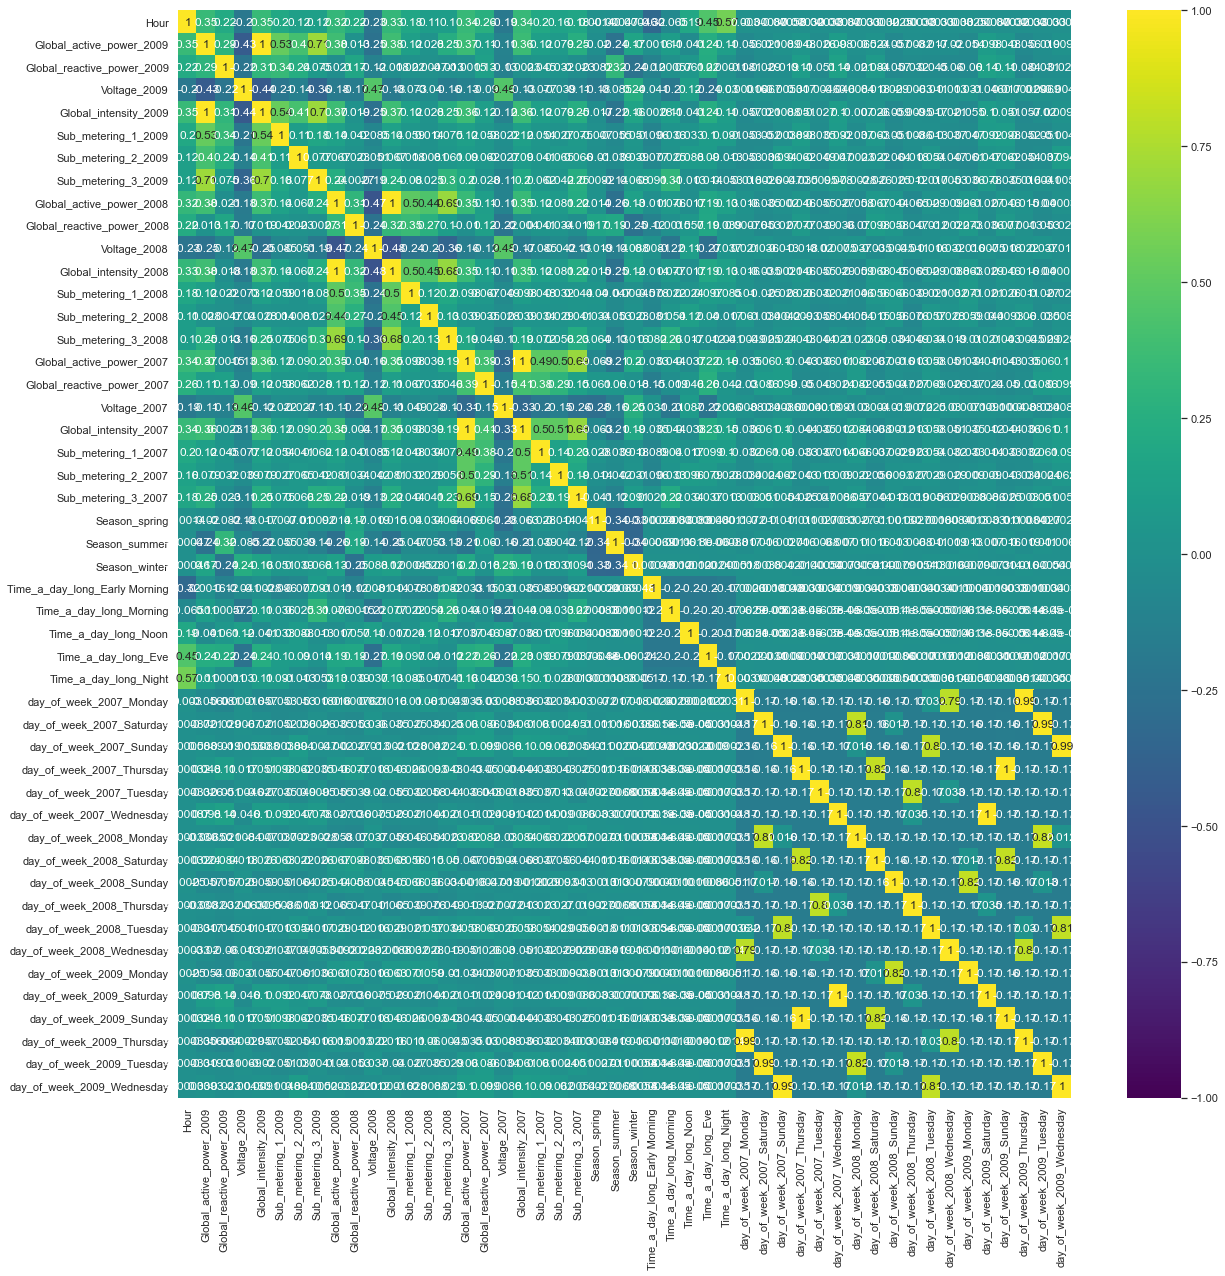

In [33]:
sns.set(rc={'figure.figsize':(20,20)})
corrMatrix = train.corr()
sns.heatmap(corrMatrix, vmin=-1.,vmax=1, annot=True, cmap="viridis")

In [111]:
train= train.drop(columns = {'Date','Hour'})
test = test.drop(columns = {'Date','Hour'})

KeyError: "['Hour' 'Date'] not found in axis"

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [113]:
print(train.shape)
print(test.shape)

(8716, 41)
(7651, 41)


In [114]:
test = test.drop(columns = {'Global_reactive_power_2010', 'Voltage_2010', 'Global_intensity_2010', 'Sub_metering_1_2010', 'Sub_metering_2_2010','Sub_metering_3_2010'})
train = train.drop(columns = {'Global_reactive_power_2009', 'Voltage_2009', 'Global_intensity_2009', 'Sub_metering_1_2009', 'Sub_metering_2_2009','Sub_metering_3_2009'})

KeyError: "['Sub_metering_2_2010' 'Sub_metering_1_2010' 'Global_intensity_2010'\n 'Global_reactive_power_2010' 'Voltage_2010' 'Sub_metering_3_2010'] not found in axis"

### Global_active_power

In [115]:
train_x = train.drop(columns = {'Global_active_power_2009'}).to_numpy()
train_y = train['Global_active_power_2009'].to_numpy()

test_x = test.drop(columns = {'Global_active_power_2010'}).to_numpy()
test_y = test['Global_active_power_2010'].to_numpy()

In [ ]:
mm_scaler = MinMaxScaler().fit(train_x)

train_x = mm_scaler.transform(train_x)
test_x = mm_scaler.transform(test_x)

In [116]:


xg_reg = xgb.XGBRegressor(seed=123,booster = 'dart', n_estimators=20, gamma= 0.5,
                          max_depth= 4,
                          min_child_weight= 5,
                          reg_alpha= 0.2,
                          reg_lambda= 0.2,
                          subsample= 1.0)

xg_reg.fit(train_x, train_y)

y_pred = xg_reg.predict(test_x)
y_pred_t = xg_reg.predict(train_x)

In [124]:
best_param_no = grid_search.best_index_ 
print('Best params set:',grid_search.best_params_, '(no. {0})'.format(best_param_no))
print('Best params score:',grid_search.best_score_ )

Best params set: {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0} (no. 53)
Best params score: 0.22237936302454608


In [121]:
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
rmse_train = np.sqrt(mean_squared_error(train_y, y_pred_t))

mae = sklearn.metrics.mean_absolute_error(test_y, y_pred)
mae_train = sklearn.metrics.mean_absolute_error(train_y, y_pred_t)

r2_score_ = r2_score(test_y, y_pred)
r2_score_train = r2_score(train_y, y_pred_t)

In [122]:
print('Global_active_power, MinMaxScaler: \n')
print("Średnia wartość cechy: ", test_y.mean())
print("Maksymalna wartość cechy: ", test_y.max(), "\n")

print("r2_score train: ", r2_score_train)
print("r2_score: ", r2_score_, '\n')

print("RMSE train: ", rmse_train)
print("RMSE: ", rmse, '\n')

print("MAE train: ", mae_train)
print("MAE: ", mae, '\n')

Global_active_power, MinMaxScaler: 

Średnia wartość cechy:  63.521992942099075
Maksymalna wartość cechy:  337.61 

r2_score train:  0.45769007571024733
r2_score:  0.28975670509046136 

RMSE train:  37.30527854907619
RMSE:  39.52306334444113 

MAE train:  27.867407718005445
MAE:  29.638150130561463 



In [123]:
print('Global_active_power, StandardScaler: \n')
print("Średnia wartość cechy: ", test_y.mean())
print("Maksymalna wartość cechy: ", test_y.max(), "\n")

print("r2_score train: ", r2_score_train)
print("r2_score: ", r2_score_, '\n')

print("RMSE train: ", rmse_train)
print("RMSE: ", rmse, '\n')

print("MAE train: ", mae_train)
print("MAE: ", mae, '\n')

Global_active_power, StandardScaler: 

Średnia wartość cechy:  63.521992942099075
Maksymalna wartość cechy:  337.61 

r2_score train:  0.45769007571024733
r2_score:  0.28975670509046136 

RMSE train:  37.30527854907619
RMSE:  39.52306334444113 

MAE train:  27.867407718005445
MAE:  29.638150130561463 



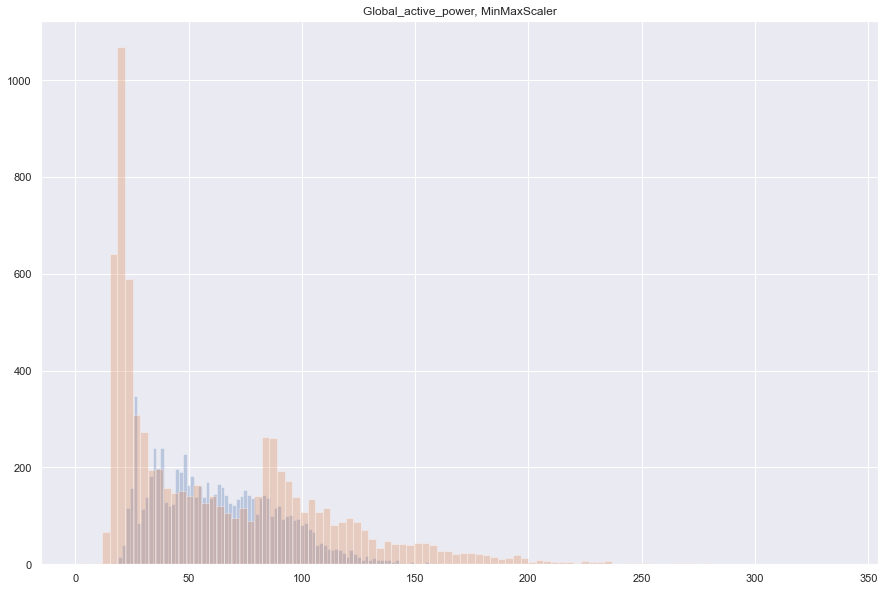

In [119]:
plt.figure(figsize=(15, 10));
plt.hist(y_pred, bins=100, alpha=0.3);
plt.hist(test_y, bins=100, alpha=0.3);
plt.title('Global_active_power, MinMaxScaler');

Global_active_power, StandardScaler: 

Średnia wartość cechy:  63.521992942099075
Maksymalna wartość cechy:  337.61 

r2_score train:  0.45769007571024733
r2_score:  0.28975670509046136 

RMSE train:  37.30527854907619
RMSE:  39.52306334444113 

MAE train:  27.867407718005445
MAE:  29.638150130561463 



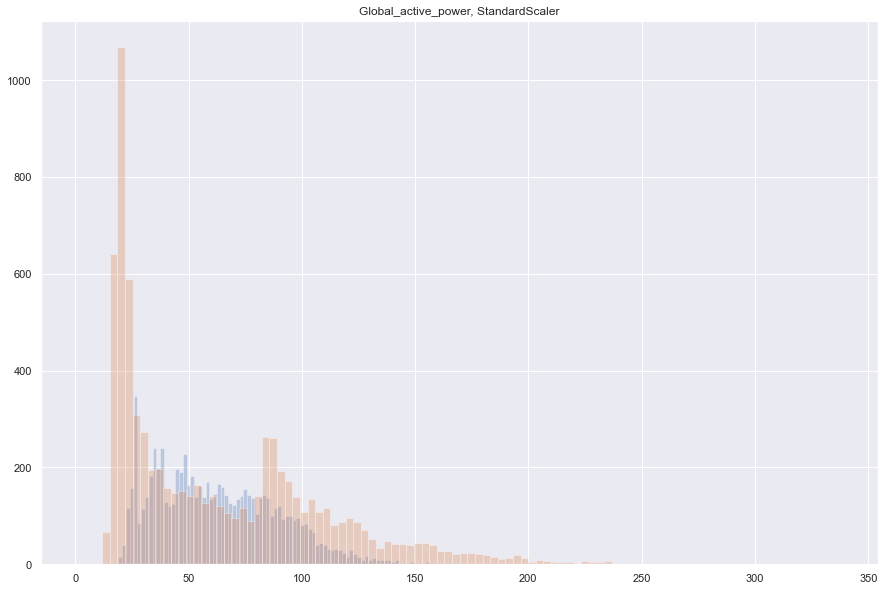

In [120]:
ss_scaler = StandardScaler().fit(train_x)

train_x = ss_scaler.transform(train_x)
test_x = ss_scaler.transform(test_x)



xg_reg = xgb.XGBRegressor(seed=123,booster = 'dart', n_estimators=20, gamma= 0.5,
                          max_depth= 4,
                          min_child_weight= 5,
                          reg_alpha= 0.2,
                          reg_lambda= 0.2,
                          subsample= 1.0)

xg_reg.fit(train_x, train_y)

y_pred = xg_reg.predict(test_x)
y_pred_t = xg_reg.predict(train_x)


rmse = np.sqrt(mean_squared_error(test_y, y_pred))
rmse_train = np.sqrt(mean_squared_error(train_y, y_pred_t))

mae = sklearn.metrics.mean_absolute_error(test_y, y_pred)
mae_train = sklearn.metrics.mean_absolute_error(train_y, y_pred_t)

r2_score_ = r2_score(test_y, y_pred)
r2_score_train = r2_score(train_y, y_pred_t)

print('Global_active_power, StandardScaler: \n')
print("Średnia wartość cechy: ", test_y.mean())
print("Maksymalna wartość cechy: ", test_y.max(), "\n")

print("r2_score train: ", r2_score_train)
print("r2_score: ", r2_score_, '\n')

print("RMSE train: ", rmse_train)
print("RMSE: ", rmse, '\n')

print("MAE train: ", mae_train)
print("MAE: ", mae, '\n')

plt.figure(figsize=(15, 10));
plt.hist(y_pred, bins=100, alpha=0.3);
plt.hist(test_y, bins=100, alpha=0.3);
plt.title('Global_active_power, StandardScaler');

In [64]:
params = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [4,6,15],
         'reg_alpha': [0, 0.5,1],
         'reg_lambda': [0,  0.5, 1]}


clf = xgb.XGBRegressor()
grid_search = GridSearchCV(clf, param_grid=params, cv=2, return_train_score=True, verbose=2)
grid_search.fit(train_x, train_y)



Fitting 2 folds for each of 729 candidates, totalling 1458 fits
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   1.7s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   1.7s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   1.6s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   1.8s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=1.0 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   1.7s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=1.0 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   2.0s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0

[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   1.4s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   1.6s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   1.9s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   1.5s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   2.1s
[CV] gamma=0.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=

[CV]  gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   1.6s
[CV] gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   1.8s
[CV] gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   1.7s
[CV] gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   1.5s
[CV] gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=1.0 
[CV]  gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=1.0, total=   1.4s
[CV] gamma=0.5, max_depth=4, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=

[CV]  gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   5.8s
[CV] gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.6 
[CV]  gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   4.9s
[CV] gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   4.9s
[CV] gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.8 
[CV]  gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   6.4s
[CV] gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0 
[CV]  gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0, total=   4.0s
[CV] gamma=0.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, 

[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   2.9s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.6, total=   3.5s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.6, total=   3.3s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   3.8s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   3.2s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.

[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   3.9s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   5.0s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   4.8s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   4.3s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   4.1s
[CV] gamma=0.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gam

[CV]  gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   5.6s
[CV] gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=1.0 
[CV]  gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=1.0, total=   5.1s
[CV] gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=1.0 
[CV]  gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=0.5, reg_lambda=1, subsample=1.0, total=   3.9s
[CV] gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6, total=   3.6s
[CV] gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6, total=   2.9s
[CV] gamma=0.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8 
[CV] 

[CV]  gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   2.4s
[CV] gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0 
[CV]  gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0, total=   2.2s
[CV] gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0 
[CV]  gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0, total=   2.2s
[CV] gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   1.9s
[CV] gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   1.8s
[CV] gamma=0.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_la

[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   8.9s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   8.4s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0, total=   7.1s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0, total=   7.1s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   8.3s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsam

[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   3.2s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   4.3s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   6.1s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0, total=   6.1s
[CV] gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0 
[CV]  gamma=0.5, max_depth=15, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0, total=   6.5s
[CV] gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV] 

[CV]  gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6, total=   5.1s
[CV] gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6 
[CV]  gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.6, total=   5.1s
[CV] gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8, total=   5.5s
[CV] gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8, total=   5.2s
[CV] gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0 
[CV]  gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0, total=   5.4s
[CV] gamma=0.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0 
[CV] 

[CV]  gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0, subsample=1.0, total=   6.0s
[CV] gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   4.9s
[CV] gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   4.9s
[CV] gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   5.2s
[CV] gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=0.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   4.9s
[CV] gamma=0.5, max_depth=15, min_child_weight=10, reg

[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0, total=   2.6s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=0.5, subsample=1.0, total=   1.9s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   1.6s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   1.6s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   1.3s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gam

[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   1.2s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0, total=   1.3s
[CV] gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0, total=   1.3s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   1.5s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   1.5s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=1.5

[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8, total=   2.9s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8 
[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=0.8, total=   2.9s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0, total=   2.6s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0, total=   2.9s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   2.6s
[CV] gamma=1.5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gam

[CV]  gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   2.7s
[CV] gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   3.5s
[CV] gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   2.8s
[CV] gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0, total=   2.5s
[CV] gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0, total=   2.5s
[CV] gamma=1.5, max_depth=4, min_child_weight=10, reg_alpha=0

[CV]  gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   3.7s
[CV] gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   3.7s
[CV] gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   3.9s
[CV] gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   3.9s
[CV] gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0 
[CV]  gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0, total=   4.2s
[CV] gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0 
[CV]  gamma=1.5

[CV]  gamma=1.5, max_depth=6, min_child_weight=1, reg_alpha=1, reg_lambda=1, subsample=1.0, total=   2.6s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   2.2s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   1.9s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   2.3s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   2.0s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=1.0 
[CV]  gamma=1.5

[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0, total=   1.9s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0, subsample=1.0, total=   1.9s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   1.9s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   2.2s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   2.2s
[CV] gamma=1.5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[

[CV]  gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   2.8s
[CV] gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0, total=   2.6s
[CV] gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0, total=   2.7s
[CV] gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   2.2s
[CV] gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   2.3s
[CV] gamma=1.5, max_depth=6, min_child_weight=10, reg_alpha=0.5, reg_

[CV]  gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   2.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   2.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0 
[CV]  gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0, total=   2.6s
[CV] gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0 
[CV]  gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0, total=   2.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6 
[CV]  gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   2.6s
[CV] gamma=1.5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6 

[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   1.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   2.0s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   2.0s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=1.0 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   2.2s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=1.0 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   2.1s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV

[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   1.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   1.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   2.1s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   2.1s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   2.2s
[CV] gamma=1.5, max_depth=15, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, 

[CV]  gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0, total=   1.9s
[CV] gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   1.6s
[CV] gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   1.6s
[CV] gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   1.8s
[CV] gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.8 
[CV]  gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   1.8s
[CV] gamma=1.5, max_depth=15, min_child_weight=10, reg_alpha=0.5, re

[CV]  gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=1.0, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   0.5s
[CV] gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=1.0 
[CV]  gamma=5, ma

[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.6, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.6, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=5, ma

[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=1.0 
[CV]  gamma=5, max_depth=4, min_c

[CV]  gamma=5, max_depth=4, min_child_weight=10, reg_alpha=0.5, reg_lambda=1, subsample=1.0, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.6, total=   0.5s
[CV] gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.6, total=   0.5s
[CV] gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=0.8, total=   0.6s
[CV] gamma=5, max_depth=4, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=1.0 
[CV]  gamma=5, max_dept

[CV]  gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0, subsample=1.0, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=1.

[CV]  gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=0.5, subsample=1.0, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=0.8, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=1.0 
[CV]  gamma=5, max_depth=6, min_c

[CV]  gamma=5, max_depth=6, min_child_weight=5, reg_alpha=1, reg_lambda=1, subsample=1.0, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=0.8, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=1.0 
[CV]  gamma=5, max_depth=6

[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0, subsample=1.0, total=   0.9s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.6, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=0.8, total=   0.8s
[CV] gamma=5, max_depth=6, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=1.0 
[CV]  g

[CV]  gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0, total=   2.6s
[CV] gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   2.5s
[CV] gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.6, total=   2.6s
[CV] gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   2.7s
[CV] gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8, total=   2.8s
[CV] gamma=5, max_depth=15, min_child_weight=1, reg_alpha=0.5, reg_lambda=1, subsample=1.0 
[CV

[CV]  gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0, reg_lambda=1, subsample=1.0, total=   4.6s
[CV] gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   3.9s
[CV] gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.6, total=   4.2s
[CV] gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   4.4s
[CV] gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=0.8, total=   4.4s
[CV] gamma=5, max_depth=15, min_child_weight=5, reg_alpha=0.5, reg_lambda=0, subsample=1.0 
[CV]  g

[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0, subsample=1.0, total=   4.9s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.6, total=   4.4s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.6, total=   4.3s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   4.5s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=0.8, total=   4.9s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=0, reg_lambda=0.5, subsample=1.

[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   4.5s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=1.0 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=0.5, subsample=1.0, total=   4.5s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   4.0s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.6 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.6, total=   3.9s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.8, total=   4.3s
[CV] gamma=5, max_depth=15, min_child_weight=10, reg_alpha=1, reg_lambda=1, subsample=0.8 
[CV]  gam

[Parallel(n_jobs=1)]: Done 1458 out of 1458 | elapsed: 67.5min finished


Best params set: {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0} (no. 53)
Best params score: 0.22237936302454608


In [65]:
best_param_no = grid_search.best_index_ 
print('Best params set:',grid_search.best_params_, '(no. {0})'.format(best_param_no))
print('Best params score:',grid_search.best_score_ )

Best params set: {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0} (no. 53)
Best params score: 0.22237936302454608
